#### Understanding the concepts of PCA

This notbook involves in applying the PCA technique on two of the 10 classes of FashinMINST dataset and visualising the top
24 eigen vectors as images. The top 24 PCs are then used to reconstruct images from each class, MSE error is calculated between reconstructed and the original images to understand the information loss.


In [25]:
# importing essential libraries

import numpy as np
import pandas as pd

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import timeit

In [26]:
# Importing PCA 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [27]:
# Loading Training and Testing datasets from torchvision.datasets module with image normalization:
transform_data = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))]) #Since it has been mentioned
# that the dataset images are Grayscale, the number of channels will be 1. So one value for mean and std.deviation has been 
# assigned in transforms.Normalize

train_data_T = datasets.FashionMNIST(root = './data', download = False, 
                                     train = True, transform = transform_data)

test_data_T = datasets.FashionMNIST(root = './data', download = False, 
                                    train = False, transform = transform_data)

In [28]:
# Creating a data Loader with batch size of 60,000 (length of training data)
batchsize = len(train_data_T)
train_data_loader_all = torch.utils.data.DataLoader(train_data_T, shuffle = False, batch_size = batchsize, num_workers = 2)
# test_data_loader = torch.utils.data.DataLoader(test_data, shuffle = False, batch_size = batchsize, num_workers = 2)

In [29]:
print(train_data_T.class_to_idx)

{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


In [30]:
# Converting the loaded tensor into a 2 dimensional matrix
image_matrix, labels = next(iter(train_data_loader_all))
image_matrix = image_matrix.view(-1,28*28)
image_matrix = image_matrix.numpy()

# Making an image matrix dataframe
image_df = pd.DataFrame(image_matrix)

# Creating label series for 60000 training data
labels = labels.numpy()
labels_series = pd.Series(labels)

# Filtering the dataframe to using label series to obtain classes 0 and 1
image_df = image_df[(labels_series == 0)|(labels_series == 1)]

# Converting the filtered dataframe back to tensor
image_matrix = torch.tensor(image_df.to_numpy())

In [31]:
# performing a scaler operation on the filtered image matrix
scaler = StandardScaler()
scaler.fit(image_matrix)
image_matrix_scaled = scaler.transform(image_matrix)
print(image_matrix_scaled.shape)

(12000, 784)


In [32]:
# Using a PCA to find the principal components
pca = PCA(0.90)
image_matrix_scaled_components = pca.fit(image_matrix_scaled)
print(image_matrix_scaled_components.components_[:].shape)

(106, 784)


In [33]:
# Creating a covariance matrix to determine the eigenvalues
cov_matrix = np.dot(image_matrix_scaled.T, image_matrix_scaled)/len(image_matrix_scaled)
print(cov_matrix.shape)

# Collecting the eigenalues in a list for each eigen vectors
eigenvalue_list = []
for eigenvector in image_matrix_scaled_components.components_[:24]:
    eigenvalue_list.append(np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)))

# Filtering the top 24 eigen vectors
components_24 = image_matrix_scaled_components.components_[:24]
print(components_24.shape)

(784, 784)
(24, 784)


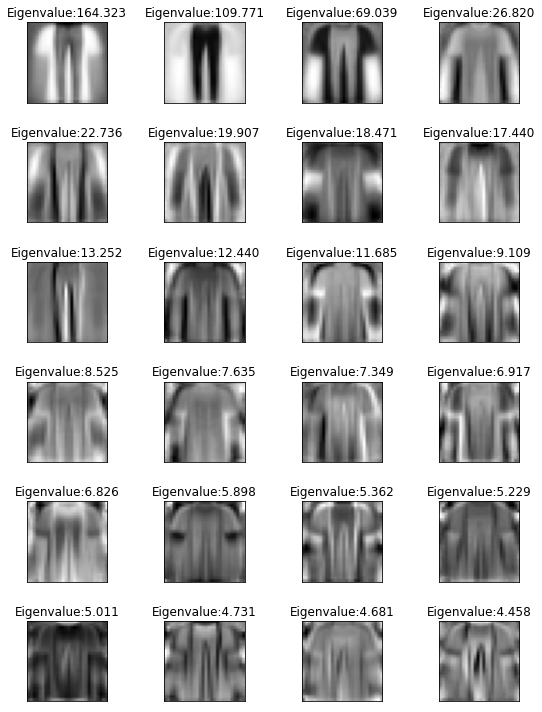

In [34]:
# Plotting the top 24 eigenvectors starting from the ones corresponding to the largest 
# eigenvalues to the smallest.
plt.figure(figsize = (8,10))
for i in range(6):
    for j in range(4):
        plt.subplot(6,4,i*4+j+1)
        plt.imshow(components_24[i*4+j].reshape(28,28), cmap = "gray")
        plt.xticks([])
        plt.yticks([])
        plt.title("Eigenvalue:"+"%.3f"%eigenvalue_list[i*4+j])
plt.tight_layout(h_pad=2)
plt.show()

##### REconstruction

In [35]:
# Reconstructing the image_matrix;
image_matrix_dimensions_reduced = pca.transform(image_matrix_scaled)

In [12]:
# Obtaining the image matrix for the top 24 components:
image_matrix_dimensions_reduced = image_matrix_dimensions_reduced[:,:24]
inverse_image_matrix_dimensions_reduced = np.dot(image_matrix_dimensions_reduced, components_24)

In [14]:
# Creating a copy of reconstructed images
check = inverse_image_matrix_dimensions_reduced

# inverse scaler transforming the component matrix to add back the mean:
inverse_image_matrix_dimensions_reduced = scaler.inverse_transform(inverse_image_matrix_dimensions_reduced)

In [15]:
# Obtaining the list of classes
labels_2_classes = labels_series[(labels_series == 0) | (labels_series == 1)]
labels_2_classes = list(labels_2_classes)

In [16]:
# function for Computing MSE error
MSE = {0:[], 1:[]}
def MSE_fn(label, actual, reconstructed):
    val = np.square(np.subtract(actual, reconstructed)).sum()
    MSE[label].append(val)

In [17]:
# Filtering fo 15 images from each class (0 and 1) 
original_0 = []
original_1 = []
list_0 = []
list_1 = []
check_0 = []
check_1 = []
i = 0
while((len(list_0)<15) or (len(list_1)<15)):
    if labels_2_classes[i] == 0:
        list_0.append(inverse_image_matrix_dimensions_reduced[i])
        original_0.append(image_matrix[i])
        check_0.append(check[i])
    else:
        list_1.append(inverse_image_matrix_dimensions_reduced[i])
        original_1.append(image_matrix[i])
        check_1.append(check[i])
    i+=1

In [18]:
# Calculating MSE error for each corresponding images:
for i in range(15):
    MSE_fn(0, original_0[i].numpy(), list_0[i])
    MSE_fn(1, original_1[i].numpy(), list_1[i])

In [19]:
add = sum(MSE[0]) + sum(MSE[1])
MSE_error = add/(30*784)
print("The MSE_error for 30 reconstructed images:",MSE_error)

The MSE_error for 30 reconstructed images: 0.05412404444805177


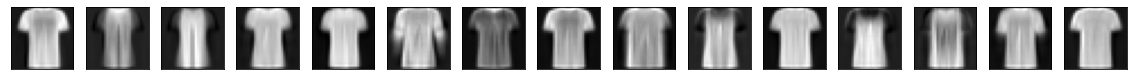

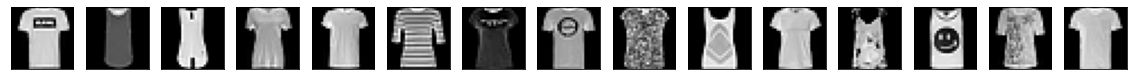

Reconstructed images without inverse transformation


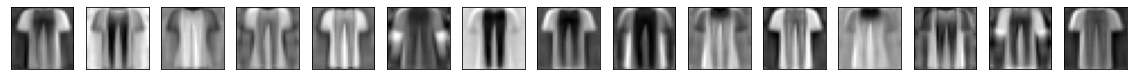

In [20]:
# Printing the filtered images for class 0 (Shirts):

# Reconstructed images
plt.figure(figsize = (20,15))
for i in range(15):
    plt.subplot(1,15, i+1)
    plt.imshow(list_0[i].reshape(28,28), cmap = "gray")
    plt.xticks([])
    plt.yticks([])

# Corresponding Original images
plt.figure(figsize = (20,15))
for i in range(15):
    plt.subplot(1,15, i+1)
    plt.imshow(original_0[i].reshape(28,28), cmap = "gray")
    plt.xticks([])
    plt.yticks([])
plt.show()
print("Reconstructed images without inverse transformation")
# Reconstructed without inverse scalar
plt.figure(figsize = (20,15))
for i in range(15):
    plt.subplot(1,15, i+1)
    plt.imshow(check_0[i].reshape(28,28), cmap = "gray")
    plt.xticks([])
    plt.yticks([])

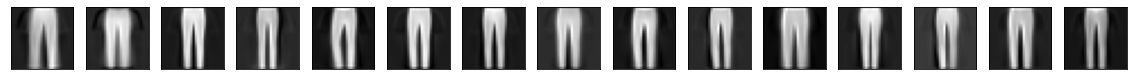

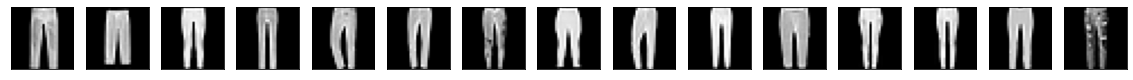

Reconstructed images without inverse transformation


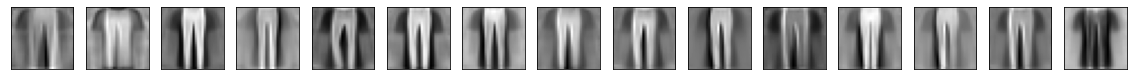

In [21]:
# Printing the filtered images for class 1 (Trousers):

# Reconstructed images
plt.figure(figsize = (20,15))
for i in range(15):
    plt.subplot(1,15, i+1)
    plt.imshow(list_1[i].reshape(28,28), cmap = "gray")
    plt.xticks([])
    plt.yticks([])

# Corresponding Original images    
plt.figure(figsize = (20,15))
for i in range(15):
    plt.subplot(1,15, i+1)
    plt.imshow(original_1[i].reshape(28,28), cmap = "gray")
    plt.xticks([])
    plt.yticks([])
plt.show()

print("Reconstructed images without inverse transformation")
# Reconstructed without inverse scalar
plt.figure(figsize = (20,15))
for i in range(15):
    plt.subplot(1,15, i+1)
    plt.imshow(check_1[i].reshape(28,28), cmap = "gray")
    plt.xticks([])
    plt.yticks([])

##### Visualisting top two Principal Components

In [23]:
# Visualising top 2 Prinicipal components
data_top2_PCs = image_matrix_dimensions_reduced[:,:2]
PC_df = pd.DataFrame(data_top2_PCs, columns = ["PC1", "PC2"])
PC_df["labels"] = labels_2_classes

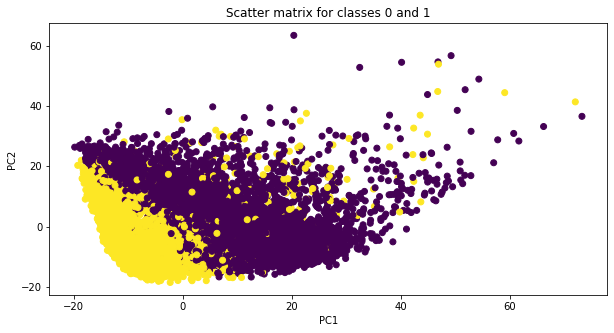

In [24]:
# Scatter plot for 12000 data instances
plt.figure(figsize = (10,5))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Scatter matrix for classes 0 and 1")
plt.scatter(PC_df["PC1"], PC_df["PC2"], c = PC_df["labels"], alpha = 1)
plt.show()

<b>Observations:</b> 

From the image representation of eigenvectors it can be seen that those vectors with higher eigenvalues produce image of better clarity compared to other vectors. Also in the images produced by the vectors of higher eigenvalue, objects from both classes ("shirts" and "trousers" in this case) are better visible compared to low eigenvalue images. It leads to an understanding that the vectors with high eigenvalues are holding more information comparatively. This means that vectors with low eigenvalues (holding less information) can be dropped safely to reduce the feature dimensions of the dataset, thus the name "dimensionality reduction".

While reconstructing the images, it is essential to perform inverse scaler operation on the dimension reduced image matrix. This operation basically adds the respective means back to the features. This operation restores the image features back to it's original scale. When mean is not added the images, all 15 images from both the classes almost appear the same without much difference between them. This is evident from the images that are reconstructed without inverse scalar operation as can be seen from above.